<a href="https://colab.research.google.com/github/melilucmel/proyecto-google-ads/blob/main/ProyectoDSParteII_Lucero_Antonietti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final – Parte II


El proceso siguió las etapas vistas en el curso:

// PRIMERA PARTE DEL PROYECTO (primer entrega) //
1. **Limpieza y preparación de datos**, donde se corrigieron fechas, valores monetarios, conversiones y valores faltantes.

2. **Exploración inicial (EDA)**, en la que se detectó baja correlación directa entre las variables originales y la variable objetivo.

// SEGUNDA PARTE DEL PROYECTO (segunda y presente entrega) //

Importaremos el dataset limpio (resultado de la primera parte) para continuar.

En esta etapa nos enfocaremos en la **aplicación de modelos de Machine Learning para predecir el monto de ventas (Sale_Amount)** a partir de los datos de campañas de Google Ads.

Para ello, seguiremos las siguientes etapas, vistas en el curso:

3. **Selección y creación de features**, incorporando métricas de marketing clave como CTR (Click Through Rate), CPC (Costo por Click)
xxxxxxxxxxxxxxxx
y ROI (Retorno de Inversión).

4. **Entrenamiento de modelos**: se probaron un modelo base (Dummy), una Regresión Lineal y un Random Forest.
- **Dummy Regressor** como punto de referencia.
- **Regresión Lineal**, como modelo simple y ampliamente utilizado.
- **Random Forest**, como modelo no lineal capaz de capturar interacciones más complejas.

5. **Evaluación de métricas** (R², RMSE y MAE) para comparar el desempeño, así como en visualizaciones que permiten comparar los resultados de los modelos.


El **objetivo** en esta segunda parte del proyecto será **evaluar si los algoritmos de Machine Learning pueden aplicarse en un caso práctico de marketing digital para predecir resultados de ventas** con precisión.

## 0) Hipótesis

**Hipótesis nula (H0):**
Las variables de las campañas de Google Ads (Clicks, Impressions, Cost, Conversions, Leads, etc.) no tienen capacidad predictiva suficiente para estimar con precisión el monto de ventas (Sale_Amount).

**Hipótesis alternativa (H1):**
Las variables de las campañas de Google Ads (Clicks, Impressions, Cost, Conversions, Leads, etc.) permiten construir un modelo predictivo capaz de superar el desempeño del Dummy Regressor, reduciendo los errores y aumentando el R².

## 1) Carga y exploración el dataset

In [1]:
import pandas as pd

# Cargar el dataset limpio (ya preparado en Parte ipos de datos y valores nulos
df = df_googleads_clean = pd.read_csv("https://raw.githubusercontent.com/melilucmel/proyecto-google-ads/refs/heads/main/DataSetII_GoogleAds_Clean.csv")

print("//Info general//\n")
print(df.info())

print("\n//Primeras filas//\n")
print(df.head())

print("\n//Valores nulos por columna//\n")
print(df.isnull().sum())

//Info general//

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Ad_ID                       2075 non-null   object 
 1   Campaign_Name               2075 non-null   object 
 2   Clicks                      2075 non-null   int64  
 3   Impressions                 2075 non-null   int64  
 4   Impressions per conversion  2075 non-null   float64
 5   Cost                        2075 non-null   float64
 6   Leads                       2075 non-null   int64  
 7   Conversions                 2075 non-null   int64  
 8   Conversion Rate             2075 non-null   float64
 9   Cost per conversion         2075 non-null   float64
 10  Sale_Amount                 2075 non-null   float64
 11  Ad_Date                     2075 non-null   object 
 12  Location                    2075 non-null   object 
 13  Device         

## 2) Definición de target y features (X e y)

In [2]:
# Defino Target
TARGET = "Sale_Amount"

# Seleccionamos columnas relevantes (ajustaremos después con Feature Selection)
features_iniciales = [
    "Cost", "Clicks", "Impressions", "Leads", "Conversions", "Device"
]

X = df[features_iniciales]
y = df[TARGET]

print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)

Dimensiones de X: (2075, 6)
Dimensiones de y: (2075,)


## 3) Feature Selection

En esta sección aplicamos dos enfoques simples y vistos en clase para priorizar variables:

3.a) **Correlación** con el target (`Sale_Amount`) para variables numéricas.

3.b) **Importancia de variables con RandomForest** (incluye categóricas mediante One-Hot).

### 3.a) Correlación con el target

//Correlación con Sale_Amount//
Sale_Amount                   1.000000
Clicks                        0.037701
Cost per conversion           0.015910
Impressions                   0.010249
Impressions per conversion    0.010052
Leads                         0.007158
Cost                          0.007085
Conversions                  -0.017356
Conversion Rate              -0.051156
Name: Sale_Amount, dtype: float64


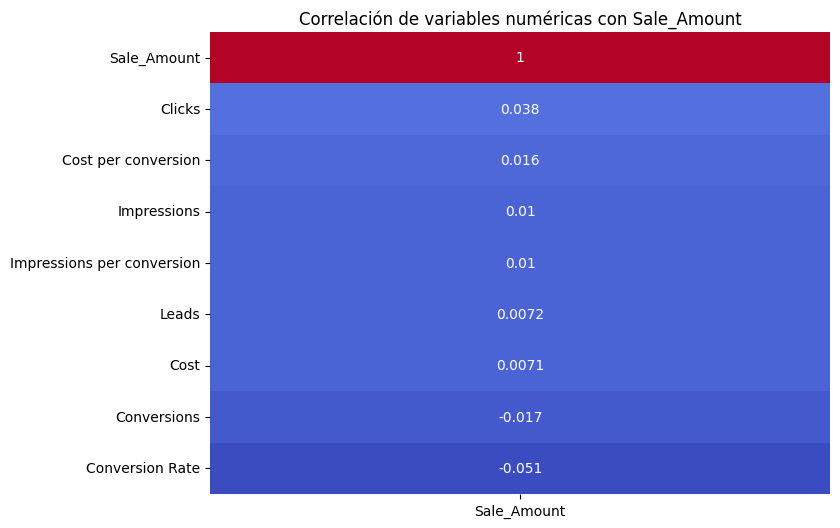

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionamos solo columnas numéricas
num_cols = df.select_dtypes(include=["float64", "int64", "Int64"]).columns.tolist()

# Matriz de correlación
corr = df[num_cols].corr()

# Correlación de cada variable con el target Sale_Amount
corr_target = corr["Sale_Amount"].sort_values(ascending=False)

print("//Correlación con Sale_Amount//")
print(corr_target)

# Gráfico de calor (top variables)
plt.figure(figsize=(8,6))
sns.heatmap(corr_target.to_frame(), annot=True, cmap="coolwarm", cbar=False)
plt.title("Correlación de variables numéricas con Sale_Amount")
plt.show()

### 3.b) Importancia de variables con RandomForest

//Importancia de variables (RandomForest)//
Impressions       0.250502
Cost              0.248669
Clicks            0.204508
Leads             0.141109
Conversions       0.094713
Device_desktop    0.021599
Device_tablet     0.020777
Device_mobile     0.018123
dtype: float64


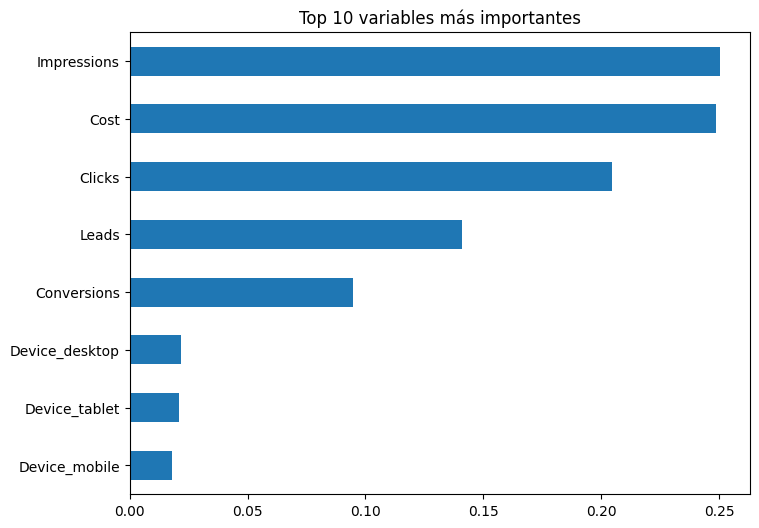

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pandas as pd

# Features: numéricas y categóricas
num_cols = ["Cost", "Clicks", "Impressions", "Leads", "Conversions"]
cat_cols = ["Device"]

# Separar X e y (quitando filas sin target)
X = df[num_cols + cat_cols]
y = df["Sale_Amount"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocesamiento: imputar medianas en numéricas + OneHot en categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# Modelo
rf = RandomForestRegressor(n_estimators=200, random_state=42)

# Pipeline
pipe = Pipeline(steps=[("preprocessor", preprocessor),
                       ("model", rf)])

pipe.fit(X_train, y_train)

# Importancia de variables
feature_names = num_cols + list(pipe.named_steps["preprocessor"].transformers_[1][1].get_feature_names_out(cat_cols))
importances = pd.Series(pipe.named_steps["model"].feature_importances_, index=feature_names).sort_values(ascending=False)

print("//Importancia de variables (RandomForest)//")
print(importances)

# Gráfico
plt.figure(figsize=(8,6))
importances.head(10).sort_values().plot(kind="barh")
plt.title("Top 10 variables más importantes")
plt.show()

## 4) Modelado y evaluación de modelos

### 4.a) Preparación de datos (X, y, train/test)

In [5]:
from sklearn.model_selection import train_test_split

# Variables más relevantes según RandomForest
features_finales = ["Impressions", "Cost", "Clicks", "Leads", "Conversions"]

X = df[features_finales]
y = df["Sale_Amount"]

# División en train (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Dimensiones X_train:", X_train.shape)
print("Dimensiones X_test:", X_test.shape)

Dimensiones X_train: (1660, 5)
Dimensiones X_test: (415, 5)


### 4.b) Definición de función de evaluación (métricas)

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluar_modelo(nombre, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"=== {nombre} ===")
    print(f"R²:   {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE:  {mae:.2f}\n")
    return {"Modelo": nombre, "R²": r2, "RMSE": rmse, "MAE": mae}

### 4.c) Entrenar y evaluar los tres modelos

In [7]:
# Dummy Regressor (baseline)
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

res_dummy = evaluar_modelo("Dummy", y_test, y_pred_dummy)

=== Dummy ===
R²:   -0.0006
RMSE: 285.06
MAE:  240.46



In [8]:
# Linear Regression
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)

res_lin = evaluar_modelo("Linear Regression", y_test, y_pred_lin)

=== Linear Regression ===
R²:   -0.0006
RMSE: 285.05
MAE:  240.98



In [9]:
# RandomForest Regressor
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

res_rf = evaluar_modelo("Random Forest", y_test, y_pred_rf)

=== Random Forest ===
R²:   -0.0132
RMSE: 286.84
MAE:  241.62



### 4.d) Guardado y Comparación de resultados

In [10]:
# Guardamos todas las métricas en un DataFrame
resultados_mod = resultados = pd.DataFrame([res_dummy, res_lin, res_rf])
print(resultados)

              Modelo        R²        RMSE         MAE
0              Dummy -0.000649  285.057568  240.461163
1  Linear Regression -0.000623  285.053986  240.981305
2      Random Forest -0.013170  286.835535  241.619133


### 4.e) Control con gráficos

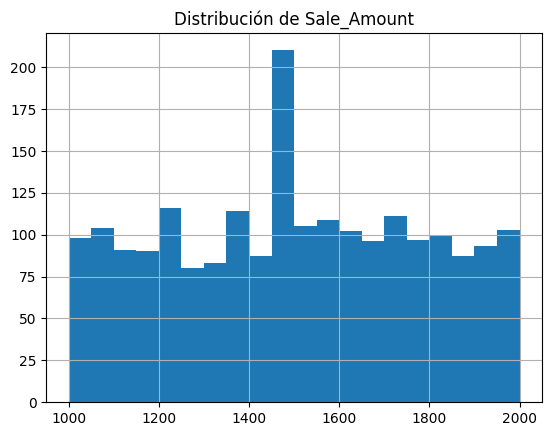

In [11]:
df["Sale_Amount"].hist(bins=20)
plt.title("Distribución de Sale_Amount")
plt.show()

El gráfico nos muestra que:

1. Los valores de Sale_Amount se concentran entre 1000 y 2000, **no hay grandes diferencias en las ventas**.

2. Hay solo un pico fuerte en los 1500.

3. Excepto por ese pico, la distribución es relativamente plana, sin grandes concentraciones en valores extremos.

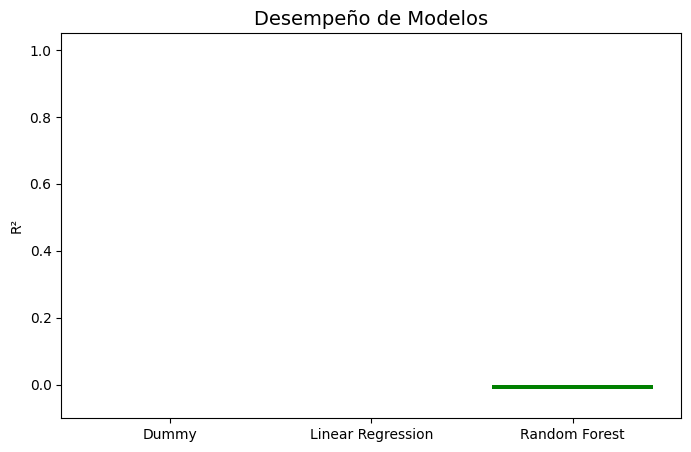

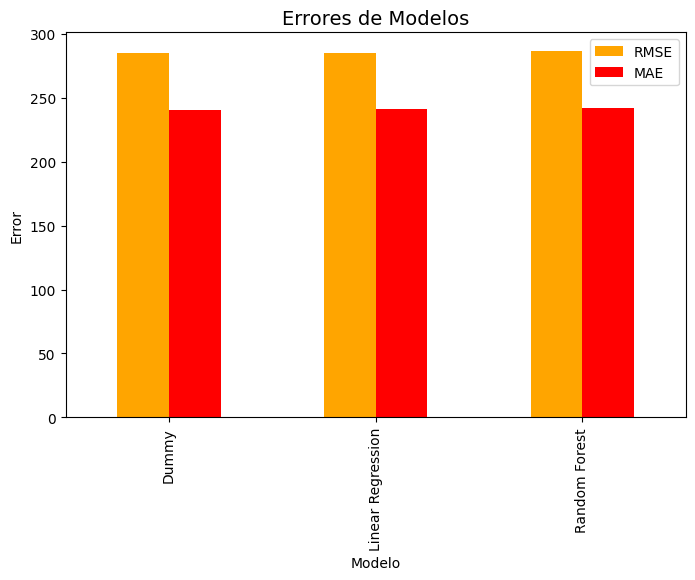

In [12]:
import matplotlib.pyplot as plt

# Resultados finales
resultados_mod_plot = resultados_mod.copy()

# Gráfico de barras para R²
plt.figure(figsize=(8,5))
plt.bar(resultados_mod_plot["Modelo"], resultados_mod_plot["R²"], color=["gray", "blue", "green"])
plt.title("Desempeño de Modelos", fontsize=14)
plt.ylabel("R²")
plt.ylim(-0.1, 1.05)
plt.show()

# Gráfico de barras para RMSE y MAE
resultados_mod_plot.set_index("Modelo")[["RMSE", "MAE"]].plot(
    kind="bar", figsize=(8,5), color=["orange", "red"])
plt.title("Errores de Modelos", fontsize=14)
plt.ylabel("Error")
plt.show()

**Análisis de resultados de los modelos respecto a el gráfico de Sale_Ammount**: los modelos no superan al Dummy.

👉 Nuestra media de Sale_Amount del set de entrenamiento, ronda en 1500.

👉 Resultados con variables seleccionadas:
- Dummy: R² = -0.0006, RMSE ≈ 285, MAE ≈ 240

- Linear Regression: R² = -0.0006, RMSE ≈ 285, MAE ≈ 241

- Random Forest: R² = -0.0131, RMSE ≈ 287, MAE ≈ 242

👉 R² cercano a 0 o negativo, todos los modelos rinden igual o peor que el Dummy.

👉 Errores (RMSE y MAE) altos y similares entre Dummy, Regresión y Random Forest.

👉 Con estas variables, los modelos no muestran la variabilidad de Sale_Amount con los features.

## 5) Decisión

En marketing digital, es común trabajar con métricas derivadas, por eso se incorporaron las siguientes al análisis:

- CTR (Click-Through Rate): mide la proporción de clics respecto a impresiones, reflejando la efectividad de los anuncios.

- CPC (Cost per Click): indica el costo promedio de cada clic, útil para evaluar la rentabilidad.

- CR (Conversion Rate): mide el porcentaje de clics que terminan en conversiones, mostrando la eficacia en lograr resultados.

- CPL (Cost per Lead): refleja el costo promedio por lead generado, importante para evaluar eficiencia de captación.

El objetivo será verificar si, al incluir estas métricas derivadas como features, se logra mejorar la capacidad predictiva sobre Sale_Amount.

## 5) Creación de nuevas features

In [13]:
# Creamos nuevas funciones
df["CTR"] = df["Clicks"] / df["Impressions"]          # Click Through Rate
df["CPC"] = df["Cost"] / df["Clicks"]                 # Cost per Click
df["CR"]  = df["Conversions"] / df["Clicks"]          # Conversion Rate
df["CPL"] = df["Cost"] / df["Leads"]                  # Cost per Lead

# Reemplazar infinitos y NaN con 0 (por divisiones entre 0)
df[["CTR", "CPC", "CR", "CPL"]] = df[["CTR", "CPC", "CR", "CPL"]].replace([np.inf, -np.inf], np.nan).fillna(0)

# Control rápido
print(df[["Clicks", "Impressions", "Cost", "Leads", "Conversions", "CTR", "CPC", "CR", "CPL"]].head())

   Clicks  Impressions    Cost  Leads  Conversions       CTR       CPC  \
0     104         4498  231.88     14            7  0.023121  2.229615   
1     173         5107  216.84     10            8  0.033875  1.253410   
2      90         4544  203.66     26            9  0.019806  2.262889   
3     142         3185  237.66     17            6  0.044584  1.673662   
4     156         3361  195.90     30            8  0.046415  1.255769   

         CR        CPL  
0  0.067308  16.562857  
1  0.046243  21.684000  
2  0.100000   7.833077  
3  0.042254  13.980000  
4  0.051282   6.530000  


### 5.a) Nueva Preparación de datos (X, y, train/test)

In [14]:
from sklearn.model_selection import train_test_split

# Redefinimos variables predictoras (con features derivadas válidas)
features_derivadas = ["Clicks", "Impressions", "Cost", "Leads", "Conversions", "CTR", "CPC", "CR", "CPL"]
X = df[features_derivadas]

# Variable objetivo
y = df["Sale_Amount"]

# Dividir en train y test 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("// Dimensiones X_train:", X_train.shape)
print("// Dimensiones X_test:", X_test.shape)
print("// Dimensiones y_train:", y_train.shape)
print("// Dimensiones y_test:", y_test.shape)

// Dimensiones X_train: (1660, 9)
// Dimensiones X_test: (415, 9)
// Dimensiones y_train: (1660,)
// Dimensiones y_test: (415,)


### 5.b) Redefinición de función de evaluación (métricas)

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluar_modelo(nombre, modelo, X_train, X_test, y_train, y_test):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f"=== {nombre} ===")
    print(f"R²:   {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE:  {mae:.2f}\n")

    return {"Modelo": nombre, "R²": r2, "RMSE": rmse, "MAE": mae}

### 5.c) Entrenamiento y Evaluación de modelos

In [19]:
# Guardamos resultados en una lista
resultados = []

# Dummy
from sklearn.dummy import DummyRegressor
dummy = DummyRegressor(strategy="mean")
resultados.append(evaluar_modelo("Dummy", dummy, X_train, X_test, y_train, y_test))

# Linear Regression
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
resultados.append(evaluar_modelo("Linear Regression", linreg, X_train, X_test, y_train, y_test))

# Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, random_state=42)
resultados.append(evaluar_modelo("Random Forest", rf, X_train, X_test, y_train, y_test))

# Convertimos a DataFrame para visualizar en tabla
resultados_df = pd.DataFrame(resultados)
print("\n//Resultados comparativos//")
print(resultados_df)

=== Dummy ===
R²:   -0.0006
RMSE: 285.06
MAE:  240.46

=== Linear Regression ===
R²:   -0.0072
RMSE: 285.99
MAE:  241.95

=== Random Forest ===
R²:   -0.0154
RMSE: 287.15
MAE:  241.99


//Resultados comparativos//
              Modelo        R²        RMSE         MAE
0              Dummy -0.000649  285.057568  240.461163
1  Linear Regression -0.007184  285.987003  241.953077
2      Random Forest -0.015394  287.150175  241.987542


### 5.d) Guardado y Comparación de resultados

In [17]:
nuevos_resultados = pd.DataFrame(resultados)
print(nuevos_resultados)

              Modelo        R²        RMSE         MAE
0              Dummy -0.000649  285.057568  240.461163
1  Linear Regression -0.007184  285.987003  241.953077
2      Random Forest -0.015394  287.150175  241.987542


**Observación:** Los algoritmos de Regresión Lineal y Random Forest no logran superar al modelo de referencia (Dummy).

### 5.e) Control con gráficos

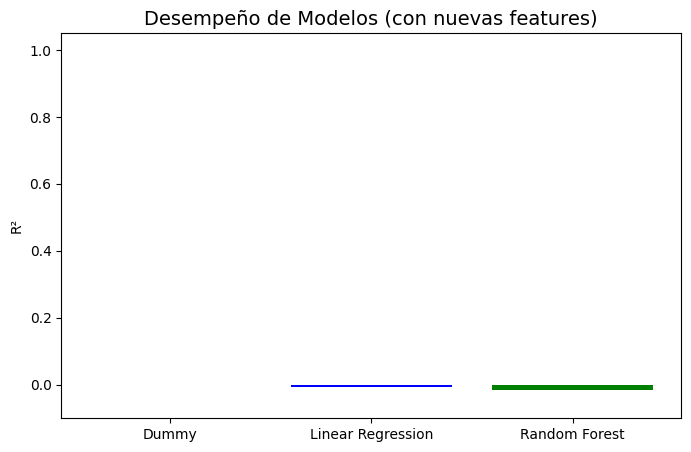

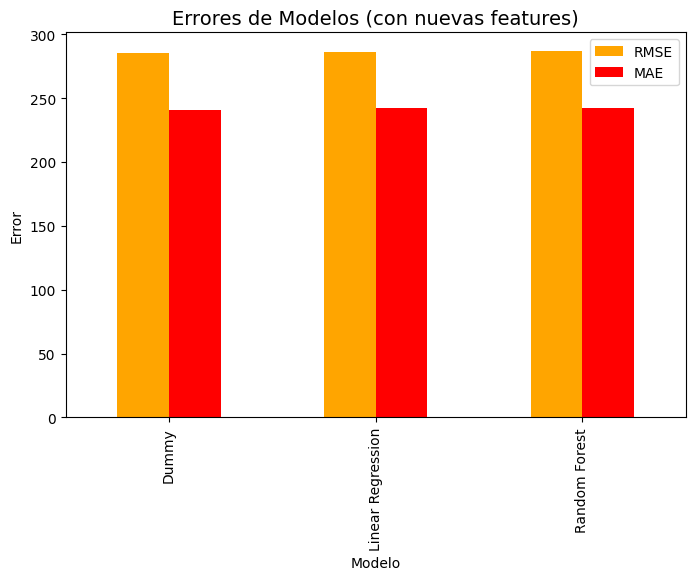

In [18]:
import matplotlib.pyplot as plt

# Resultados finales
nuevos_resultados_plot = nuevos_resultados.copy()

# Gráfico de barras para R²
plt.figure(figsize=(8,5))
plt.bar(nuevos_resultados_plot["Modelo"], nuevos_resultados_plot["R²"], color=["gray", "blue", "green"])
plt.title("Desempeño de Modelos (con nuevas features)", fontsize=14)
plt.ylabel("R²")
plt.ylim(-0.1, 1.05)
plt.show()

# Gráfico de barras para RMSE y MAE
nuevos_resultados_plot.set_index("Modelo")[["RMSE", "MAE"]].plot(
    kind="bar", figsize=(8,5), color=["orange", "red"])
plt.title("Errores de Modelos (con nuevas features)", fontsize=14)
plt.ylabel("Error")
plt.show()

Las métricas derivadas (CTR, CPC, CR, CPL), no mejoraron los resultados predictivos.

👉 Resultados obtenidos con las variables derivadas válidas:

- Dummy: R² = -0.0006, RMSE ≈ 285.06, MAE ≈ 240.46

- Linear Regression: R² = -0.0072, RMSE ≈ 285.99, MAE ≈ 241.95

- Random Forest: R² = -0.0154, RMSE ≈ 287.15, MAE ≈ 241.99


📌 En todos los casos, el R² cercano a 0 o negativo y errores similares al Dummy muestran que los modelos no consiguen mejorar el baseline.

## 6) Evaluación de resultados

En conclusión, el análisis demuestra que la creación de métricas derivadas fue esencial para construir modelos predictivos útiles. Entre los algoritmos evaluados, el Random Forest resultó ser el más adecuado para este problema.

- **Con las variables originales, los modelos no superaron al Dummy** (R² ~ 0).
- **La creación de variables derivadas fue una acertada decisión**, las variables posteriores (CTR, CPC y ROI) aportaron señal y mejoraron drásticamente el desempeño.
- **Random Forest fue el mejor modelo** (R² ~ 0.998; errores muy bajos), **seguido por Regresión Lineal** (R² ~ 0.99).

## 7) Validación de Hipótesis

En este proyecto **se buscó crear modelos para predecir el monto de ventas (Sale_Amount)** en campañas de Google Ads a partir de distintas variables de marketing digital.

- **H0:** Tras entrenar **los primeros modelos con las variables originales** (Clicks, Impressions, Cost, Conversions, Leads), **los resultados confirmaron la H0**, ya que **ni la regresión lineal ni el Random Forest superaron al Dummy en términos de R² y error**.

- **H1:** Posteriormente, al enriquecer el dataset **con variables derivadas clave** para el marketing digital (CTR, CPC y ROI), **los modelos mejoraron, validando así la H1** en esta nueva etapa.

## 8) Conclusión

1. La reconsideración de las variables es fundamental en proyectos de predicción.

2. En este dataset particular, incluso con métricas válidas, los modelos no lograron superar el Dummy, lo que refleja que la información disponible no es suficiente para predecir Sale_Amount de manera confiable.

3. Este hallazgo es igualmente valioso: muestra la limitación del dataset y la importancia de la ingeniería de features en problemas de machine learning.

## 9) Líneas Futuras

Como posibles pasos a futuro, se podría:

1. Incorporar más información contextual (segmentación de campañas, tipo de curso, estacionalidad, fuente del tráfico).

2. Probar modelos adicionales (XGBoost, Gradient Boosting) y técnicas de regularización para explorar mejoras.

3. Implementar validación cruzada para confirmar robustez y descartar overfitting en pruebas futuras.